<a href="https://colab.research.google.com/github/KhaingLae/TensorFlow_DeepLearning_Bootcamp/blob/main/03_introduction_to_computer_vision_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Convolutional Neural Networks and Computer Vision with TensorFlow

Computer vision is the practice of writhing algorithms which can discover patterns in visual data such as the camera of self-driving car regonizing the car in front.

## Get the data

The images we're working with are from Food101 dataset (101 different classes of food): https://www.kaggle.com/dansbecker/food-101

However we've modeified it to only use two classes (pizza 🍕 and steak ) using the image data modification notebook:

https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

> 🔑 **Note** : We start with a smaller dataset so we can experiment quickly and figure what works (or bett yet what doesn't work) before scaling up.

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2025-04-03 08:22:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.203.207, 142.250.98.207, 142.251.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   210MB/s    in 0.5s    

2025-04-03 08:22:06 (210 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



## Inspect the data

It's very crucial step at the beginning of any machine learning project is becoming one with it

And for a computer vision project.. this usually means visualizing many samples of your data.

In [ ]:
!ls pizza_steak

test  train


In [ ]:
!ls pizza_steak/train/

pizza  steak


In [ ]:
!ls pizza_steak/train/steak | head -5

1000205.jpg
100135.jpg
101312.jpg
1021458.jpg
1032846.jpg


In [ ]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

There are 2 directories and 0 images in "pizza_steak".
There are 2 directories and 0 images in "pizza_steak/train".
There are 0 directories and 750 images in "pizza_steak/train/steak".
There are 0 directories and 750 images in "pizza_steak/train/pizza".
There are 2 directories and 0 images in "pizza_steak/test".
There are 0 directories and 250 images in "pizza_steak/test/steak".
There are 0 directories and 250 images in "pizza_steak/test/pizza".


In [ ]:
# Another way to find out how many images are in a file
num_steak_images_train = len(os.listdir("pizza_steak/train/steak"))

num_steak_images_train

750

To visualize our images, first let's get the class names programmtically.

In [ ]:
# Get the classnames programmatically

import pathlib
import numpy as np
data_dir = pathlib.Path("pizza_steak/train/")
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['pizza' 'steak']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target image directory
  target_folder = target_dir+target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape:{img.shape}")
  return img

['2514432.jpg']
Image shape:(384, 512, 3)


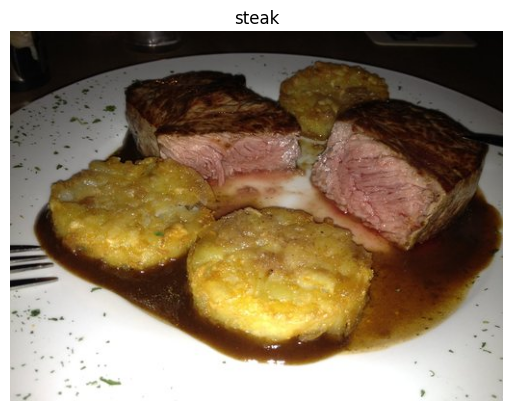

In [ ]:
# View a random image from training data set

img = view_random_image(target_dir="pizza_steak/train/",
                        target_class="steak")

In [ ]:
# View the image shape
img.shape # returns width, height, colour channels

(384, 512, 3)

In [ ]:
# Get all the pixel values between 0 and 1 (Normalization)
img/255

array([[[0.19215686, 0.16470588, 0.09411765],
        [0.19215686, 0.16470588, 0.09411765],
        [0.19607843, 0.16078431, 0.09411765],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.2       , 0.17254902, 0.10196078],
        [0.2       , 0.17254902, 0.10196078],
        [0.20392157, 0.16862745, 0.10196078],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       [[0.21176471, 0.18039216, 0.10588235],
        [0.21176471, 0.18039216, 0.10588235],
        [0.21960784, 0.17647059, 0.10588235],
        ...,
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784],
        [0.01960784, 0.01960784, 0.01960784]],

       ...,

       [[0.82352941, 0.81176471, 0.79215686],
        [0.82352941, 0.81176471, 0.79215686],
        [0.82352941, 0

## An end-to-end example

Let's build a covulutional neural network to find patterns in our images, more specificall we need way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# set the seed
tf.random.set_seed(42)

# Preprocess data (Normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our directories
train_dir = "/content/pizza_steak/train"
test_dir = "pizza_steak/test"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224), # reshape 525, 525 to 224, 224 (standard)
                                               batch_size=32,
                                               class_mode='binary',
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,batch_size=32,
                                             target_size=(224, 224),
                                             class_mode='binary',
                                             seed=42)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10,
                           kernel_size=3,
                           activation="relu",
                           input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(pool_size=2,
                              padding="valid"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6280 - loss: 0.6341 - val_accuracy: 0.8140 - val_loss: 0.4208
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.7734 - loss: 0.4814 - val_accuracy: 0.8380 - val_loss: 0.4117
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 119s 3s/step - accuracy: 0.8109 - loss: 0.4363 - val_accuracy: 0.8560 - val_loss: 0.4060
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.8167 - loss: 0.4222 - val_accuracy: 0.8580 - val_loss: 0.3516
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.8450 - loss: 0.3857 - val_accuracy: 0.8360 - val_loss: 0.3871


> 🔑 **Note**: If the above cell is taking longer than -10 seconds per epoch, make sure youre using GPU.

In [ ]:
# Get a model summary
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │          28,091 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 93,305 (364.48 KB)

 Trainable params: 31,101 (121.49 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,204 (242.99 KB)

⚒ **Practice/Exercis**e : Go through the CNN explainer website and compare with our solution.
https://poloclub.github.io/cnn-explainer

## Using the same model as before

In [ ]:
# Set random seed
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 166ms/step - accuracy: 0.4699 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 167ms/step - accuracy: 0.5015 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.4991 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.4578 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 187ms/step - accuracy: 0.5242 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931


In [ ]:
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │         602,116 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │              20 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,425 (6.89 MB)

 Trainable params: 602,141 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,204,284 (4.59 MB)

Despite having 20x more parameters than our CNN (model_1), model_2 performs terribly...

In [ ]:
# Set the ranmdom seed
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

history_3= model_3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 28s 531ms/step - accuracy: 0.5954 - loss: 3.3854 - val_accuracy: 0.7340 - val_loss: 0.7707
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.7035 - loss: 0.8742 - val_accuracy: 0.7220 - val_loss: 0.6659
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 41s 465ms/step - accuracy: 0.7481 - loss: 0.6173 - val_accuracy: 0.7300 - val_loss: 0.5621
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 40s 447ms/step - accuracy: 0.7918 - loss: 0.4435 - val_accuracy: 0.7620 - val_loss: 0.5125
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 43s 492ms/step - accuracy: 0.7042 - loss: 0.7909 - val_accuracy: 0.7800 - val_loss: 0.4542


In [ ]:
# Get Model_3 Summary
model_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │      15,052,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,219,605 (172.50 MB)

 Trainable params: 15,073,201 (57.50 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 30,146,404 (115.00 MB)

## Binary Classification: Let's break it down

1. Become one with the data (visualize)
2. Preprocess the data (normalize)
3. Create the model (start with a baseline)
4. Fit the model
5. Evaluate the model
6. Adjust the different parameters and improve the modle (try to beat baseline)
7. Repeat until satisfied (experiment)

### 1. Become one with the data

['1615395.jpg']
Image shape:(384, 512, 3)
['1247645.jpg']
Image shape:(512, 341, 3)


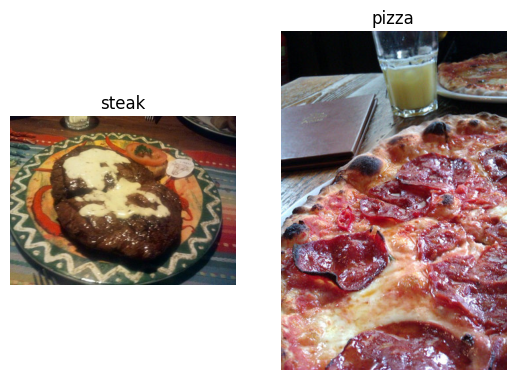

In [ ]:
# Visualize data
import matplotlib.pyplot as plt
plt.figure()
plt.subplot(1,2,1)
steak_img = view_random_image("pizza_steak/train/", "steak")
plt.subplot(1,2,2)
pizza_img = view_random_image("pizza_steak/train/", "pizza")

### 2. Preprocess the data

In [ ]:
# Define directory dataset paths
train_dir = 'pizza_steak/train'
test_dir = 'pizza_steak/test'

Our next step is to turn our data into **batches.**

A batch is a small subset of data. Rather than look at all -10,000 images at one time, a model might only look 32 at a time.

It does this for a couple of reasons:

1. 10,000 images (or more) might not fit into the memory of your processor (GPU).
2. Trying to learn the patterns in 10,000 images in one hit could result in the model not being able to learn very well.

Why 32??
Because 32 is good for health.

In [ ]:
# Create train and test data generator and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(directory=train_dir, target_size=(224,224), class_mode="binary", batch_size=32)

test_data = test_datagen.flow_from_directory(directory=test_dir, target_size=(224,224), class_mode="binary", batch_size=32)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [ ]:
# Get a sample of a train data batch
images, labels = next(train_data) # get the next batch of images
len(images), len(labels)

(32, 32)

In [ ]:
# How many batches
len(train_data)

47

In [ ]:
1500/32

46.875

In [ ]:
# Get the first of two images
images[:2], images[0].shape

(array([[[[0.56078434, 0.63529414, 0.79215693],
          [0.5647059 , 0.6392157 , 0.7960785 ],
          [0.5647059 , 0.6392157 , 0.80392164],
          ...,
          [0.07843138, 0.08235294, 0.05882353],
          [0.08235294, 0.08235294, 0.07450981],
          [0.09803922, 0.09803922, 0.09803922]],
 
         [[0.5647059 , 0.6392157 , 0.7960785 ],
          [0.5568628 , 0.6313726 , 0.7960785 ],
          [0.5568628 , 0.6313726 , 0.7960785 ],
          ...,
          [0.09803922, 0.10196079, 0.07058824],
          [0.0627451 , 0.06666667, 0.04705883],
          [0.04313726, 0.04313726, 0.03529412]],
 
         [[0.5686275 , 0.6431373 , 0.8078432 ],
          [0.5647059 , 0.6392157 , 0.80392164],
          [0.5647059 , 0.6392157 , 0.8078432 ],
          ...,
          [0.07450981, 0.07843138, 0.04705883],
          [0.15686275, 0.16078432, 0.13725491],
          [0.21568629, 0.21960786, 0.20000002]],
 
         ...,
 
         [[0.3921569 , 0.34901962, 0.22352943],
          [0.39607

In [ ]:
# View the first batch of labels
labels

array([0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

### 3. Create a CNN model (start with a baseline)

A baseline is a relatively simple model or existing result that you setup when beginning a machine experimenting, you try to beat the baseline.

> 🔑 **Note** : In deep learning, there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required.

In [ ]:
# Make the model easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
# Create the model (this will be base line, a layer convoultionay network)
model_4 = Sequential([
    Conv2D(filters=10, # number of features
           kernel_size=3, # size of filter
           strides=1,  #if valid, input shape = output shape. If "valid", inputshape compressed.
           padding="valid", #if valid, input shape = output shape. If "valid", inputshape compressed.
           activation="relu",
           input_shape=(224, 224, 3)),  # input layer (specify input shape)
    Conv2D(10, 3, activation="relu"), Flatten(),
    Dense(1, activation="sigmoid"),
        # output layer (working with binary classification so only 1 output neuron)
     # strides = 1, move 1 pixel at a time
])

In [ ]:
model_4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 484000)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │         484,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 485,191 (1.85 MB)

 Trainable params: 485,191 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])


### Fit the model

In [ ]:
len(train_data), len(test_data)

(47, 16)

In [ ]:
# Fit the model
# Define the TensorBoard callback
# logs will be written to ./logs directory
log_dir = "./logs"
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history_4 = model_4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data),
                        callbacks = [tensorboard_callback])

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.5661 - loss: 2.5184 - val_accuracy: 0.7680 - val_loss: 0.5712
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.7961 - loss: 0.4628 - val_accuracy: 0.7640 - val_loss: 0.4849
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8910 - loss: 0.3144 - val_accuracy: 0.8140 - val_loss: 0.4254
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9427 - loss: 0.1805 - val_accuracy: 0.8040 - val_loss: 0.4495
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9881 - loss: 0.0679 - val_accuracy: 0.8100 - val_loss: 0.4216


In [ ]:
model_4.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 603ms/step - accuracy: 0.8026 - loss: 0.4361


[0.4215761721134186, 0.8100000023841858]

In [ ]:
model_1.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 729ms/step - accuracy: 0.8329 - loss: 0.3932


[0.38709306716918945, 0.8360000252723694]

### 5. Evaluating our model

<Axes: >

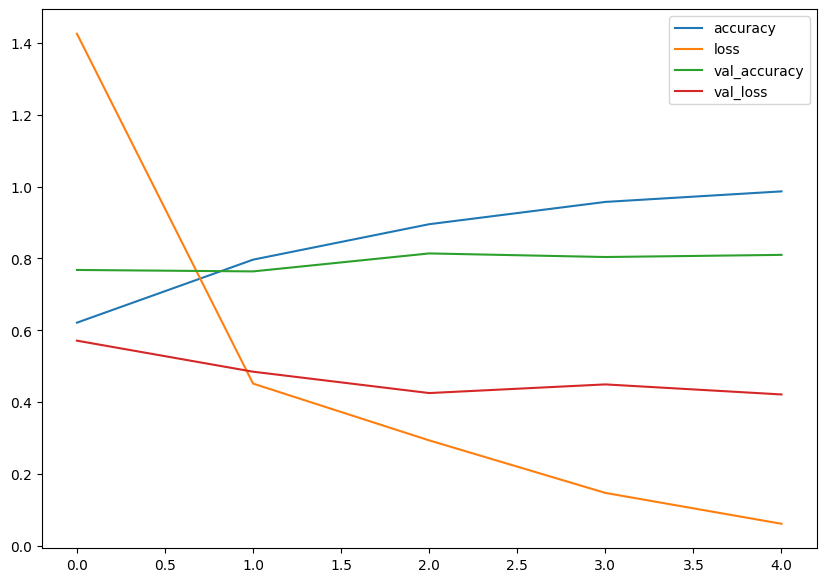

In [ ]:
import pandas as pd
pd.DataFrame(history_4.history).plot(figsize=(10, 7))

In [ ]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

> 🔑 Note: When a model's **validation loss starts to increase**, it's likely thhat the model is **overfitting** the training dataset. This means, it's learning the patterns in the training dataset **too well** and thus the models' ability to generalize to unseen data will be diminished.

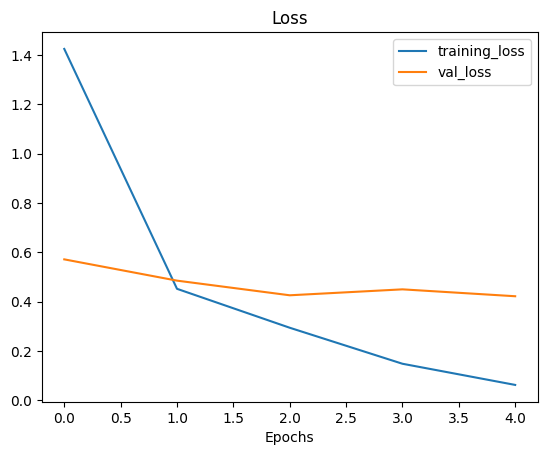

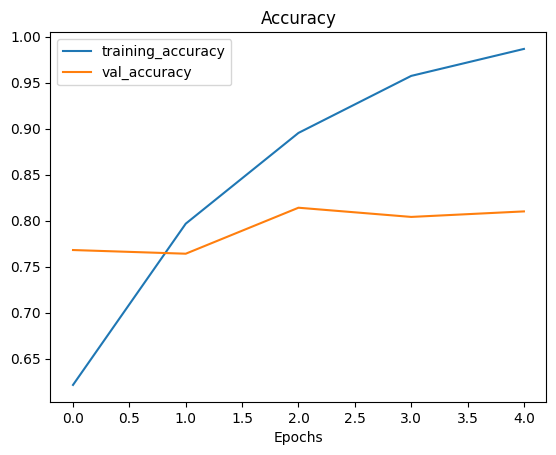

In [ ]:
# Check out the loss and accuracy of model_4
plot_loss_curves(history_4)

### 6. Adjust the model parameters

Fitting a machine learning model comes in 3 steps:

0. Create a baseline
1. Beat the baseline by overfitting a larger model
2. Reduce overfitting

Ways to induce overfitting:

* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of our flattened layer

Reduce overfitting:
* Add data argumentation
* Add regularization layers (such as MaxPool2D)
* Add more data...

> 🔑 **Note**: Reducing overfitting is known as **regularization**.

In [ ]:
# Create the model (this is going t be our new baseline)

model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_5 = model_5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.6101 - loss: 0.6342 - val_accuracy: 0.8080 - val_loss: 0.4710
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.7863 - loss: 0.4657 - val_accuracy: 0.8220 - val_loss: 0.4069
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8122 - loss: 0.4189 - val_accuracy: 0.8460 - val_loss: 0.3531
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8138 - loss: 0.3988 - val_accuracy: 0.8460 - val_loss: 0.3470
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.8127 - loss: 0.4237 - val_accuracy: 0.8540 - val_loss: 0.3436


In [ ]:
model_5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 111, 111, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 54, 54, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 10)          │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 26, 26, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 6760)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │           6,761 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,585 (103.85 KB)

 Trainable params: 8,861 (34.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,724 (69.24 KB)

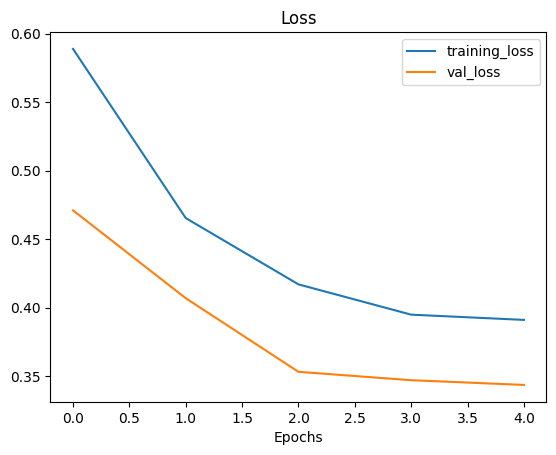

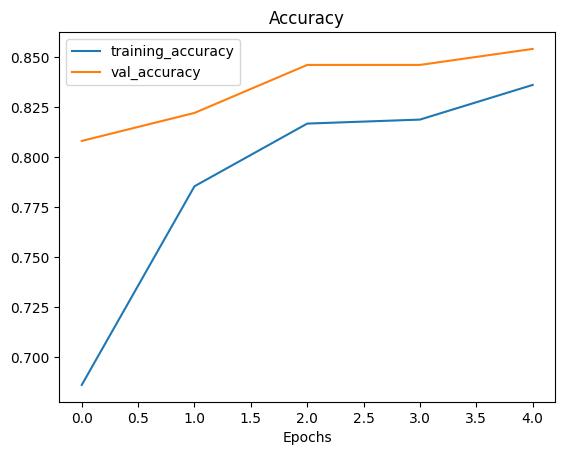

In [ ]:
# Plot loss curves
plot_loss_curves(history_5)

### Opening our bag of tricks and finding data argumentation

In [ ]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                              rotation_range=0.2,
                                              shear_range=0.2,
                                              zoom_range=0.2,
                                             width_shift_range=0.2,
                                             height_shift_range=0.3,
                                             horizontal_flip=True)

# Create ImageDataGenerator instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1/255.)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(rescale=1/255.)

> 🤔 **Question:** What is data augementation?


Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable (hopefully) patterns.

Altering might mean adjusting the rotation of an image, flipping it, cropping it or something similar.


In [ ]:
# Import data and augment it from training directory
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, target_size=(224, 224), class_mode="binary", batch_size=32, shuffle=False) # for demonstration purpose only

# Create non-augmented train data batches
print("Non-argumented training data:")
train_data_non_augmented = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), class_mode="binary", batch_size=32, shuffle=False)

# Create non-augmented test data batches
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), class_mode="binary", batch_size=32)




Augmented training data:
Found 1500 images belonging to 2 classes.
Non-argumented training data:
Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


> 🔑 **Note**: Data augmentation is usually only performed on the training data. Using 'ImageDataGenerator' built-in data augmentation paramenters our images are left as they are in the directories but are modified as they're loaded into the model.

In [ ]:
# Get sample data batches
images, labels = next(train_data_non_augmented)
images_augmented, labels_augmented = next(train_data_augmented)


showing image number: 17


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

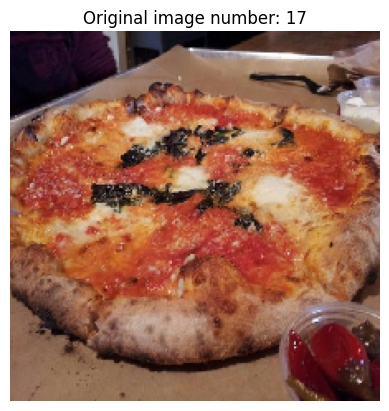

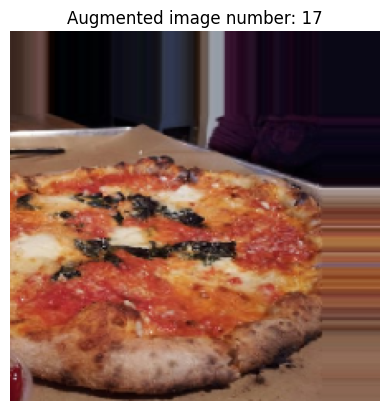

In [ ]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32) # batch sizes are 32
print(f"showing image number: {random_number}")
plt.imshow(images[random_number])
plt.title(f'Original image number: {random_number}')
plt.axis(False)
plt.figure()
plt.imshow(images_augmented[random_number])
plt.title(f'Augmented image number: {random_number}')
plt.axis(False)

Fitting Model_6 on argumented data

In [ ]:
# Create a model
model_6 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(),
    Conv2D(10,3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

# Compile the model
model_6.compile(loss="binary_crossentropy",
                optimizer=Adam(),
                metrics=["accuracy"])

# Fit the model
history_6 = model_6.fit(train_data_augmented,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.3510 - loss: 0.8146 - val_accuracy: 0.4980 - val_loss: 0.6930
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.5581 - loss: 0.6923 - val_accuracy: 0.5140 - val_loss: 0.6913
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.4757 - loss: 0.6934 - val_accuracy: 0.5660 - val_loss: 0.6920
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5249 - loss: 0.6929 - val_accuracy: 0.6200 - val_loss: 0.6907
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.5705 - loss: 0.6940 - val_accuracy: 0.5880 - val_loss: 0.6900


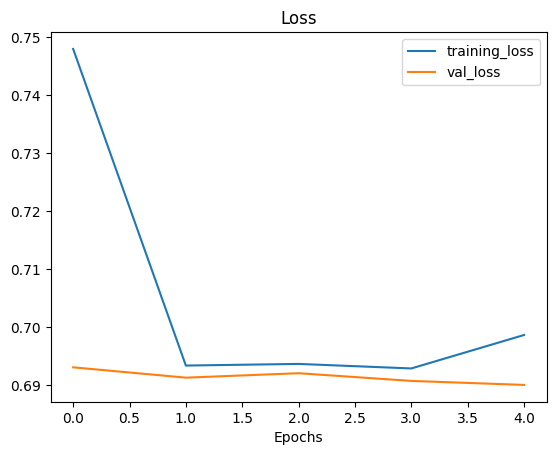

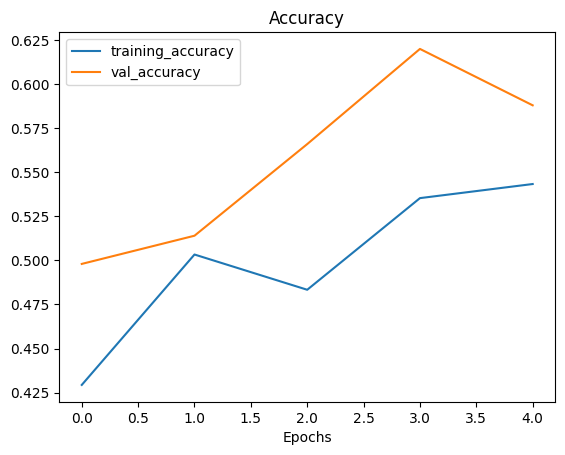

In [ ]:
# Check our model training curves
plot_loss_curves(history_6)

Let's shuffle our augmented training data and train the same model

In [ ]:
# Import data and augment it and shuffle from training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir, target_size=(224, 224), class_mode="binary", batch_size=32, shuffle=True)

Found 1500 images belonging to 2 classes.


In [ ]:
# Create the model same as above
model_7 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
           MaxPool2D(),
           Conv2D(10,3, activation="relu"),
           MaxPool2D(),
           Conv2D(10,3, activation="relu"),
           MaxPool2D(),
           Flatten(),
           Dense(1, activation="sigmoid")
])

# Compile the model
model_7.compile(loss = "binary_crossentropy",
                optimizer = Adam(),
                metrics =["accuracy"])

# Fit the model
history_7 = model_7.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5452 - loss: 0.6838 - val_accuracy: 0.7820 - val_loss: 0.5006
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6767 - loss: 0.5741 - val_accuracy: 0.8200 - val_loss: 0.4140
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7354 - loss: 0.5338 - val_accuracy: 0.7800 - val_loss: 0.4394
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7788 - loss: 0.4942 - val_accuracy: 0.8520 - val_loss: 0.3695
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7890 - loss: 0.4727 - val_accuracy: 0.8660 - val_loss: 0.3299


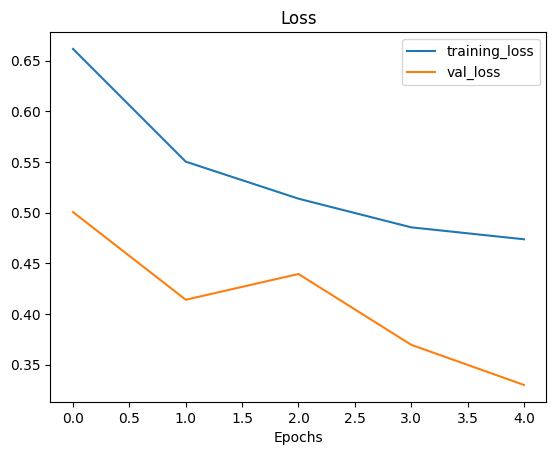

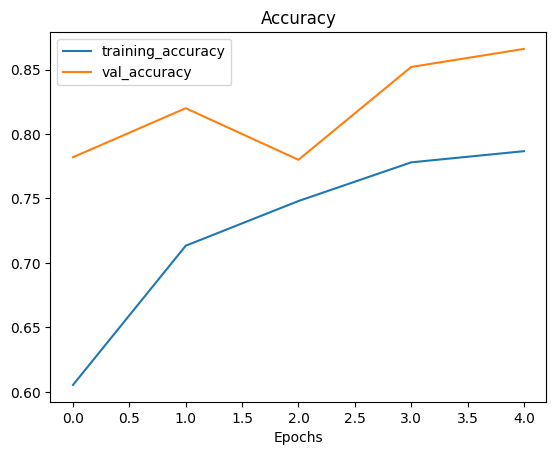

In [ ]:
# Plot loss curves
plot_loss_curves(history_7)

> 🔑 **Note**: When shuffling training data, the model gets exposed to all different kinds of data during training and learn features across a wide array of images.

### 7. Repeat until satisfied

Since we've already beaten our baseline, there are a few things we could try to continue to improve our model:

* Increase the number of model layers (e.g. add more 'Conv2D' 'MaxPool2D' layers)
* Increase the number of filters in each convolutional layer (3.g. from 10 to 32 or even 65)
* Train for longer (more epochs)
* Find the ideal learning rate
* Get more data
* Use transfer learning to leverage what another image mode has learn and adjsut it for our own use case.

## Make a prediction with our trained model on our own custom data

In [ ]:
# Classes we're working with
print(class_names)

['pizza' 'steak']


--2025-04-03 11:46:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg’

03-steak.jpeg       100%[===================>]   1.89M  --.-KB/s    in 0.07s   

2025-04-03 11:46:47 (27.5 MB/s) - ‘03-steak.jpeg’ saved [1978213/1978213]



(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

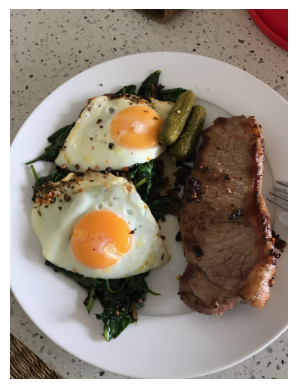

In [ ]:
# View our example image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-steak.jpeg

steak = mpimg.imread("03-steak.jpeg")
plt.imshow(steak)
plt.axis(False)



In [ ]:
steak.shape

(4032, 3024, 3)

> 🔑 **Note**: When you train a neural network and you want to make a prediction with it on your own custom data, it's important that your custom data (or new data) is preprocessed into the same format as the data your model was trained on.

In [ ]:
# Create a function  to import and image and resize it to be able to be used in our model
def load_and_prep_image (filename, image_shape=224):
  # Read the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[image_shape, image_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [ ]:
# Load in and prepocess our custom image
steak = load_and_prep_image("03-steak.jpeg")
steak

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [ ]:
pred = model_7.predict(tf.expand_dims(steak, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step


In [ ]:
class_names

array(['pizza', 'steak'], dtype='<U5')

In [ ]:
pred_class = class_names[int(tf.round(pred))]
pred_class

np.str_('steak')

In [ ]:
def pred_and_plot(model, filename, class_names= class_names):
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted value
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


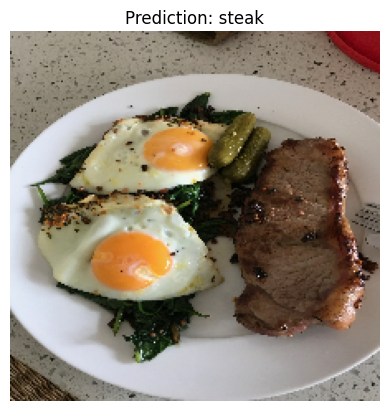

In [ ]:
pred_and_plot(model_7, "03-steak.jpeg")

--2025-04-03 12:00:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg’

03-pizza-dad.jpeg   100%[===================>]   2.74M  --.-KB/s    in 0.08s   

2025-04-03 12:00:43 (35.5 MB/s) - ‘03-pizza-dad.jpeg’ saved [2874848/2874848]



(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

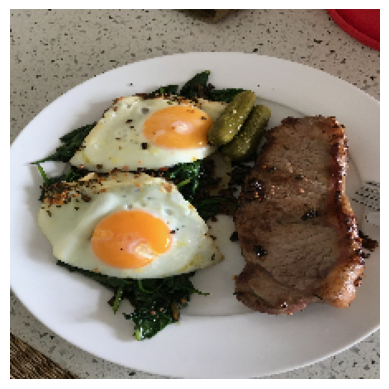

In [ ]:
# Next image
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-pizza-dad.jpeg

pizza = mpimg.imread("03-pizza-dad.jpeg")
plt.imshow(steak)
plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


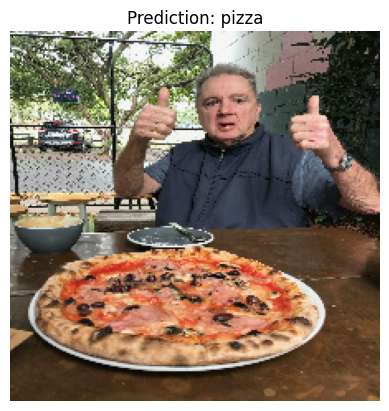

In [ ]:
pred_and_plot(model_7, "03-pizza-dad.jpeg")

## Multi-class Image Classification

1. Become one with the data
2. Preprocess the data (get it ready for a model)
3. Create a model (start with a baseline)
4. Fit the model (overfit it to make sure it works)
5. Evaluate the models
6. Adjust different hyperparameters and improve the model
7. Repeat unti satisfied.


### 1. Import and Become one of data

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip

# Unzip our data
zip_ref = zipfile.ZipFile("10_food_classes_all_data.zip")
zip_ref.extractall()
zip_ref.close()

--2025-04-05 03:32:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.188.207, 64.233.189.207, 108.177.97.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M  29.1MB/s    in 19s     

2025-04-05 03:32:26 (25.8 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
import os

# Walk through 10 classes of food images data
for dirpath, dirnames, filenames in os.walk("10_food_classes_all_data"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 

In [ ]:
!ls -la 10_food_classes_all_data/

total 16
drwxr-xr-x  4 root root 4096 Apr  5 03:32 .
drwxr-xr-x  1 root root 4096 Apr  5 03:32 ..
drwxr-xr-x 12 root root 4096 Apr  5 03:32 test
drwxr-xr-x 12 root root 4096 Apr  5 03:32 train


In [ ]:
# Setup the train and test directories
train_dir = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [ ]:
# Let's visualize our images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target image directory
  target_folder = target_dir+target_class
  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)
  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off")
  print(f"Image shape:{img.shape}")
  return img

['513251.jpg']
Image shape:(384, 512, 3)


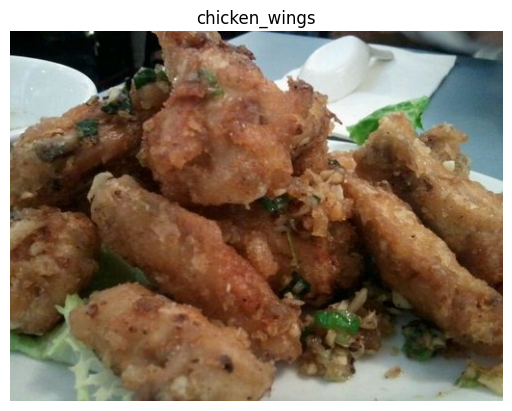

In [ ]:
# Visualize
import random
img = view_random_image(target_dir=train_dir, target_class=random.choice(class_names))

### 2. Preprocess the data (prepare it for a model)

In [ ]:
!pip install pandas=2.2.2

ERROR: Invalid requirement: 'pandas=2.2.2': Expected end or semicolon (after name and no valid version specifier)
    pandas=2.2.2
          ^
Hint: = is not a valid operator. Did you mean == ?


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescale the data
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turning it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


### 3. Create a model (start with a baseline)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Create our model similar to CNN Explainer Website
model_8 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax") # Changed to have 10 output neurons
])

# Compile the model
model_8.compile(loss="categorical_crossentropy",
               optimizer = Adam(),
               metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 4. Fit a model

In [ ]:
history_8 = model_8.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


235/235 ━━━━━━━━━━━━━━━━━━━━ 31s 110ms/step - accuracy: 0.1508 - loss: 2.2762 - val_accuracy: 0.2752 - val_loss: 2.0327
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.3035 - loss: 2.0011 - val_accuracy: 0.3184 - val_loss: 1.9159
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.4157 - loss: 1.7263 - val_accuracy: 0.3316 - val_loss: 1.8791
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.5809 - loss: 1.2715 - val_accuracy: 0.3388 - val_loss: 2.0181
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.7594 - loss: 0.7358 - val_accuracy: 0.3092 - val_loss: 2.6309


### 5. Evaluate the model

In [ ]:
# Evaluate on the test data
model_8.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.3033 - loss: 2.6466


[2.630934715270996, 0.3091999888420105]

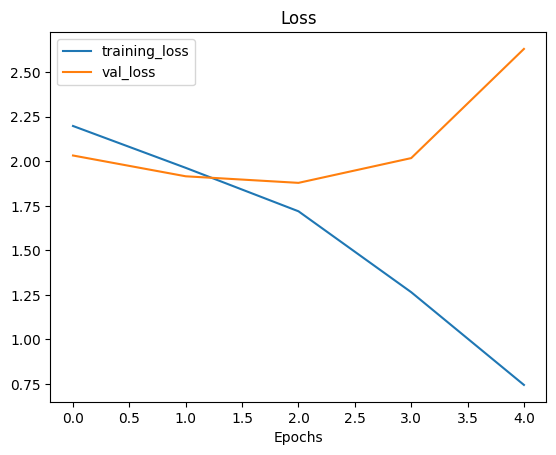

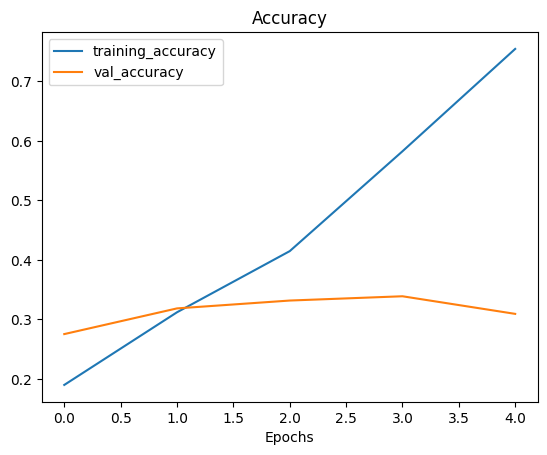

In [ ]:
# Check out the model's loss curves
plot_loss_curves(history_8)

It seems our model is **overfitting**.

### 6. Adjust the model hyperparameters (to beat the baseline/reduce overfitting)

Let's try and fix overfitting by:
* **Get more data** - having more data gives a model more opportunity to learn diverse patterns
* **Simplify the model** - if our current model is overfitting the data, it may be too complicating of a model, one way to simplify model is to reduce of layers or reduce hidden units in layers
* **Use data augmentation** - data augmentation manipulates the training data in such a way to add more original data)
* **Use transfer learning** - transfer learning leverages the patterns another model has learned on simply use thoes patterns on your data set

In [ ]:
# How about we try and simplify the model first
# Let's try to remove 2 convolutional layers...
model_9 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(10, activation="softmax") # Changed to have 10 output neurons
])

model_9.compile(loss= "categorical_crossentropy",
                optimizer = Adam(),
                metrics=["accuracy"])

In [ ]:
model_8.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         280,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 851,762 (3.25 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 567,842 (2.17 MB)

In [ ]:
# Fit the model with 2x conv layers
history_9 = model_9.fit(train_data, epochs=5, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=len(test_data))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.2145 - loss: 2.1796 - val_accuracy: 0.3488 - val_loss: 1.8676
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.4249 - loss: 1.7235 - val_accuracy: 0.3344 - val_loss: 1.9084
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.5791 - loss: 1.3563 - val_accuracy: 0.3504 - val_loss: 1.9162
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.7458 - loss: 0.8626 - val_accuracy: 0.3308 - val_loss: 2.2437
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.8632 - loss: 0.5096 - val_accuracy: 0.3164 - val_loss: 2.5766


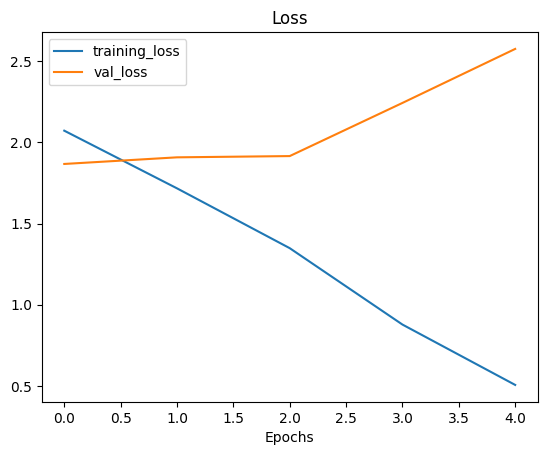

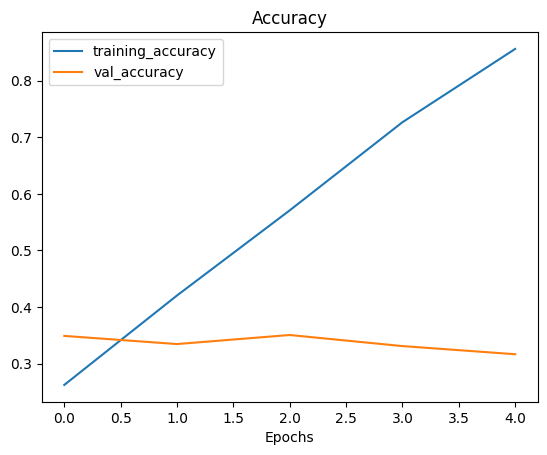

In [ ]:
 # Check out the curves of loss accuracy
 plot_loss_curves(history_9)

"Simplifying the model" experiment doesn't work.

### Trying to reduce overfitting with data augmentation

In [ ]:
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                          rotation_range=0.2,
                                          shear_range=0.2,
                                          zoom_range=0.2,
                                          width_shift_range=0.2,
                                          height_shift_range=0.2,
                                          horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode="categorical")


Found 7500 images belonging to 10 classes.


In [ ]:
# Let't create another model on the argumented data
model_10 = tf.keras.models.clone_model(model_8)

# Compile the cloned model
model_10.compile(loss="categorical_crossentropy",
                 optimizer=Adam(),
                 metrics=["accuracy"])

In [ ]:
model_10.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 10)        │             280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 10)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 10)        │             910 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 10)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 28090)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │         280,910 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 283,920 (1.08 MB)

 Trainable params: 283,920 (1.08 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
history_10 = model_10.fit(train_data_augmented,
                          epochs=5,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))

Epoch 1/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 88s 364ms/step - accuracy: 0.1209 - loss: 2.2823 - val_accuracy: 0.2104 - val_loss: 2.1377
Epoch 2/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 85s 361ms/step - accuracy: 0.2007 - loss: 2.1541 - val_accuracy: 0.2796 - val_loss: 2.0137
Epoch 3/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 84s 359ms/step - accuracy: 0.2656 - loss: 2.0885 - val_accuracy: 0.2952 - val_loss: 1.9658
Epoch 4/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 85s 360ms/step - accuracy: 0.2658 - loss: 2.0596 - val_accuracy: 0.3508 - val_loss: 1.8692
Epoch 5/5
235/235 ━━━━━━━━━━━━━━━━━━━━ 85s 362ms/step - accuracy: 0.3049 - loss: 1.9962 - val_accuracy: 0.3788 - val_loss: 1.8076


In [ ]:
model_8.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.2975 - loss: 2.6344


[2.6309332847595215, 0.3091999888420105]

In [ ]:
model_10.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - accuracy: 0.3766 - loss: 1.8194


[1.8075593709945679, 0.37880000472068787]

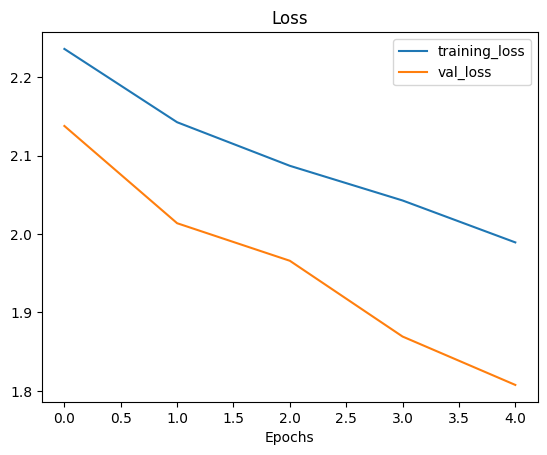

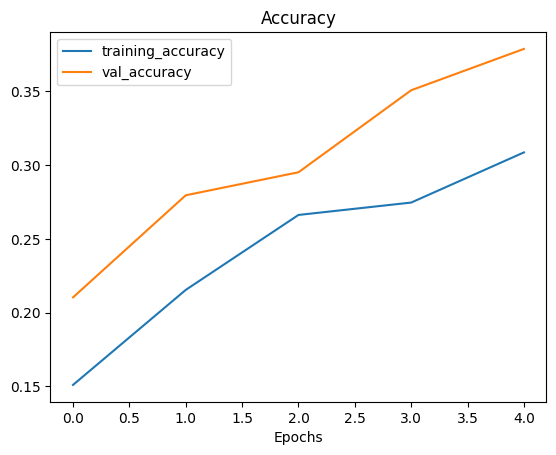

In [ ]:
plot_loss_curves(history_10)

That's looks much better...
They're heading in the right direction so if we were to train for longer, we might see further improvements...

### 7. Repeat unitl satisfied

### Make a prediction with our trained model

Let's use our trained model to make some predictions on our own custom images!

In [ ]:

class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [ ]:
# Download some custom images
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-hamburger.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-sushi.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-steak.jpeg
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-pizza-dad.jpeg

--2025-04-05 03:52:50--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-hamburger.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3564285 (3.4M) [image/jpeg]
Saving to: ‘03-hamburger.jpeg’

03-hamburger.jpeg   100%[===================>]   3.40M  9.93MB/s    in 0.3s    

2025-04-05 03:52:52 (9.93 MB/s) - ‘03-hamburger.jpeg’ saved [3564285/3564285]

--2025-04-05 03:52:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/images/03-sushi.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP requ

In [ ]:
# Reconfig pred_and_plot function to work with multiclass
def pred_and_plot(model, filename, class_names= class_names):
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class

  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


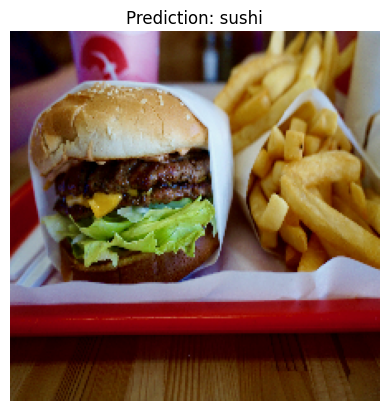

In [ ]:
# Make a prediction using Model 10
pred_and_plot(model= model_10, filename="03-hamburger.jpeg", class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


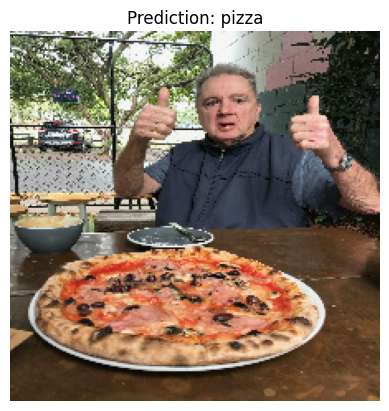

In [ ]:
pred_and_plot(model= model_10, filename="03-pizza-dad.jpeg", class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


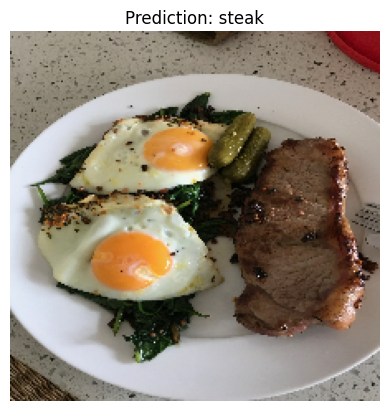

In [ ]:
pred_and_plot(model= model_10, filename="03-steak.jpeg", class_names=class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


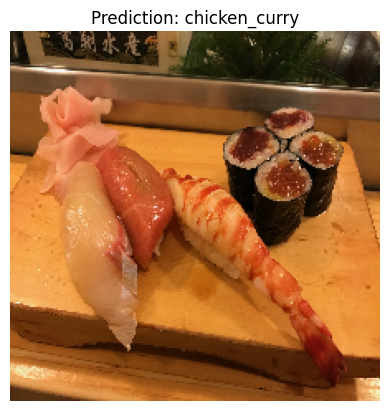

In [ ]:
pred_and_plot(model= model_10, filename="03-sushi.jpeg", class_names=class_names)

Look like our model does not perform well on custom image

### Saving and Loading our model

In [ ]:
model_10.save("saved_trained_model_10.keras")

In [ ]:
# Load in a trained model and evaluate it
loaded_model_10= tf.keras.models.load_model("saved_trained_model_10.keras")
loaded_model_10.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.3633 - loss: 1.8421


[1.8075590133666992, 0.37880000472068787]

In [ ]:
model_10.evaluate(test_data)

79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3601 - loss: 1.8369


[1.8075587749481201, 0.37880000472068787]